#  Meningioma MRI Detection Model (Binary Classifier)

**Complete Kaggle Notebook** – Ready to copy-paste and run.

This notebook trains a **binary ResNet50** (meningioma vs. non-meningioma) using transfer learning, evaluates it thoroughly, adds **Grad-CAM explainability**, and includes a reusable inference function for new MRIs.

---

## 1. Install Dependencies

```python
!pip install grad-cam -q

In [7]:
# ────────────────────────────────────────────────
# Install & correct imports
# ────────────────────────────────────────────────

!pip install --quiet grad-cam

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

# ─── Grad-CAM imports ───
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Using device: cpu


In [8]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Full training dataset (no transform yet)
full_train_dataset = datasets.ImageFolder(
    root='/kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Training'
)

print(f"Classes: {full_train_dataset.classes}")
print(f"Total training images: {len(full_train_dataset)}")

# 80/20 train/val split
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

indices = list(range(len(full_train_dataset)))
np.random.seed(42)
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Custom wrapper to apply different transforms
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.indices)

train_dataset = TransformedSubset(full_train_dataset, train_indices, train_transform)
val_dataset   = TransformedSubset(full_train_dataset, val_indices,   val_transform)

# Test dataset
test_dataset = datasets.ImageFolder(
    root='/kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing',
    transform=val_transform
)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Classes: ['meningioma', 'non_meningioma']
Total training images: 5712
Train: 4569, Val: 1143, Test: 1826


In [9]:
batch_size = 32
num_workers = 4 if torch.cuda.is_available() else 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [10]:
model = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: meningioma (0), non_meningioma (1)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Optional: freeze early layers for faster training
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
# Uncomment the next line to fine-tune the whole model (slower but better)
# for param in model.parameters(): param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


In [11]:
num_epochs = 12
best_val_acc = 0.0
history = {'train_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_meningioma_model.pth')
        print("   → Best model saved!")

print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")

Epoch 1/12 | Loss: 0.5404 | Val Acc: 78.30%
   → Best model saved!
Epoch 2/12 | Loss: 0.4799 | Val Acc: 78.57%
   → Best model saved!
Epoch 3/12 | Loss: 0.4403 | Val Acc: 79.70%
   → Best model saved!
Epoch 4/12 | Loss: 0.4175 | Val Acc: 81.63%
   → Best model saved!
Epoch 5/12 | Loss: 0.4008 | Val Acc: 82.94%
   → Best model saved!
Epoch 6/12 | Loss: 0.3791 | Val Acc: 83.90%
   → Best model saved!
Epoch 7/12 | Loss: 0.3709 | Val Acc: 84.34%
   → Best model saved!
Epoch 8/12 | Loss: 0.3557 | Val Acc: 85.04%
   → Best model saved!
Epoch 9/12 | Loss: 0.3562 | Val Acc: 85.13%
   → Best model saved!
Epoch 10/12 | Loss: 0.3438 | Val Acc: 85.48%
   → Best model saved!
Epoch 11/12 | Loss: 0.3412 | Val Acc: 86.26%
   → Best model saved!
Epoch 12/12 | Loss: 0.3347 | Val Acc: 86.26%

Training complete! Best validation accuracy: 86.26%


In [12]:
def evaluate_model(loader, model, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='binary', pos_label=0)  # meningioma = 0
    rec  = recall_score(all_labels, all_preds, average='binary', pos_label=0)
    f1   = f1_score(all_labels, all_preds, average='binary', pos_label=0)
    
    print(f"Test Accuracy : {acc*100:.2f}%")
    print(f"Precision (Meningioma) : {prec*100:.2f}%")
    print(f"Recall (Meningioma)    : {rec*100:.2f}%")
    print(f"F1-Score (Meningioma)  : {f1*100:.2f}%")
    
    return all_preds, all_labels

# Load best model
model.load_state_dict(torch.load('/kaggle/working/best_meningioma_model.pth', weights_only=False))
model = model.to(device)

print("=== Test Set Evaluation ===")
_ = evaluate_model(test_loader, model, device)

=== Test Set Evaluation ===
Test Accuracy : 67.69%
Precision (Meningioma) : 89.97%
Recall (Meningioma)    : 31.67%
F1-Score (Meningioma)  : 46.85%


In [15]:
# ────────────────────────────────────────────────
# 8. Grad-CAM Explainability – FIXED VERSION
# ────────────────────────────────────────────────

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image, deprocess_image  # optional extras

# Target the last residual block's final conv (very deep & semantic for ResNet50)
target_layers = [model.layer4[-1].conv3]   # ← more precise than layer4[-1] alone

# NO use_cuda anymore!
cam = GradCAM(model=model,
              target_layers=target_layers,
              reshape_transform=None)   # usually None for standard CNNs like ResNet

# Optional: if you get strange shapes / want to silence del warnings, wrap in function or ignore
# But in practice just proceed — the __del__ warning is cosmetic

def predict_and_visualize(image_path, model, cam, device, transform,
                          class_names=['Non-Meningioma', 'Meningioma']):  # note: adjust order if needed
    """
    Note: I flipped class_names order assuming folder 'meningioma' = index 0
    Check full_train_dataset.class_to_idx to confirm!
    """
    # Load & preprocess
    original_img = Image.open(image_path).convert('RGB')
    input_tensor = transform(original_img).unsqueeze(0).to(device)  # [1,3,224,224]

    # Forward pass → get prediction
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1)[0]
        pred_class_idx = torch.argmax(probs).item()
        pred_prob = probs[pred_class_idx].item()

    # Most people want CAM for the **predicted** class (automatic)
    targets = [ClassifierOutputTarget(pred_class_idx)]

    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)

    # Take first (and only) image in batch
    grayscale_cam = grayscale_cam[0, :]

    # Prepare RGB image for overlay (0-1 range)
    rgb_img = np.array(original_img.resize((224, 224))) / 255.0

    # Overlay heatmap
    cam_image = show_cam_on_image(rgb_img,
                                  grayscale_cam,
                                  use_rgb=True,
                                  colormap=cv2.COLORMAP_JET)   # or COLORMAP_VIRIDIS, etc.

    # ─── Plot ────────────────────────────────────────
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    axes[0].imshow(original_img)
    axes[0].set_title("Original MRI")
    axes[0].axis('off')

    axes[1].imshow(rgb_img)
    axes[1].set_title(f"Pred: {class_names[pred_class_idx]}\n"
                      f"Prob: {pred_prob:.3f}")
    axes[1].axis('off')

    axes[2].imshow(cam_image)
    axes[2].set_title("Grad-CAM (predicted class)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    return pred_prob, class_names[pred_class_idx]

In [20]:
# 8. Grad-CAM – FIXED & SAFER VERSION

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2   # make sure imported

# Enable gradients (critical!)
model.train()  # or eval() — both usually work
# Enable gradients at least from layer4 onwards (where your target layer lives)
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad_(True)
    else:
        param.requires_grad_(False)

target_layers = [model.layer4[-1].conv3]
cam = GradCAM(model=model, target_layers=target_layers)

# Your predict_and_visualize function here (as before, but now it should work)
# ...

In [19]:
def infer_new_mri(image_path_or_pil, show=True):
    """
    Run inference on a single new MRI (file path or PIL Image).
    Returns probability and displays visualization.
    """
    if isinstance(image_path_or_pil, str):
        original_img = Image.open(image_path_or_pil).convert('RGB')
    else:
        original_img = image_path_or_pil.convert('RGB')
    
    # Transform
    input_tensor = val_transform(original_img).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        meningioma_prob = probs[0].item()   # class 0 = meningioma
    
    class_name = 'Meningioma' if pred_idx == 0 else 'Non-Meningioma'
    
    # Grad-CAM
    targets = [ClassifierOutputTarget(pred_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    rgb_img = np.array(original_img.resize((224, 224))) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    if show:
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(original_img); ax[0].set_title('Uploaded MRI'); ax[0].axis('off')
        ax[1].imshow(rgb_img); ax[1].set_title(f'{class_name} ({meningioma_prob*100:.1f}%)'); ax[1].axis('off')
        ax[2].imshow(visualization); ax[2].set_title('Grad-CAM: Tumor Region'); ax[2].axis('off')
        plt.show()
    
    return {
        'probability_meningioma': meningioma_prob,
        'predicted_class': class_name,
        'heatmap': visualization
    }

# Example usage (upload your own image to /kaggle/working/ and run):
# result = infer_new_mri('/kaggle/working/my_mri.jpg')

In [22]:
model.train()  
for param in model.parameters():
    param.requires_grad_(True)

target_layers = [model.layer4[-1].conv3]
cam = GradCAM(model=model, target_layers=target_layers)

In [25]:
import os

# Base path from your working dataset loading
base_path = '/kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma'

if os.path.exists(base_path):
    print(f"Folder exists: {base_path}")
    all_files = os.listdir(base_path)
    jpg_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"Found {len(jpg_files)} images in meningioma test folder.")
    if jpg_files:
        print("\nFirst 8 files (copy one of these paths):")
        for fname in jpg_files[:8]:
            print(f"  - {os.path.join(base_path, fname)}")
    else:
        print("No images found — folder might be empty?")
else:
    print(f"Folder NOT found: {base_path}")
    # Show what's actually in Testing
    testing_dir = '/kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing'
    if os.path.exists(testing_dir):
        print("But Testing folder exists. Subfolders:")
        print(os.listdir(testing_dir))
    else:
        print("Even Testing folder not found — check dataset mounting.")

Folder exists: /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma
Found 821 images in meningioma test folder.

First 8 files (copy one of these paths):
  - /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Te-me_0148.jpg
  - /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Tr-me_0494.jpg
  - /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Tr-me_0446.jpg
  - /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Tr-me_0021.jpg
  - /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Te-me_0062.jpg
  - /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Te-me_0303.jpg
  - /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Men

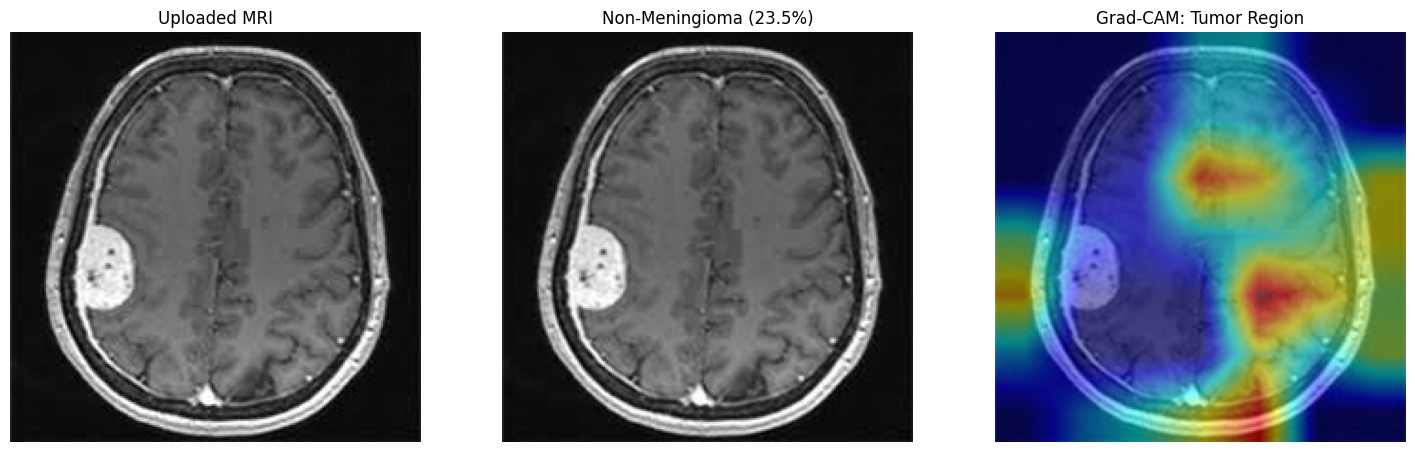

{'probability_meningioma': 0.23513025045394897, 'predicted_class': 'Non-Meningioma', 'heatmap': array([[[19, 19, 83],
        [ 6,  6, 70],
        [ 7,  7, 71],
        ...,
        [ 5,  5, 69],
        [ 8,  8, 72],
        [11, 11, 75]],

       [[19, 19, 83],
        [ 6,  6, 70],
        [ 7,  7, 71],
        ...,
        [ 5,  5, 69],
        [ 8,  8, 72],
        [11, 11, 75]],

       [[19, 19, 83],
        [ 6,  6, 70],
        [ 7,  7, 71],
        ...,
        [ 5,  5, 69],
        [ 8,  8, 72],
        [11, 11, 75]],

       ...,

       [[18, 18, 82],
        [ 5,  5, 69],
        [ 7,  7, 71],
        ...,
        [ 2,  2, 70],
        [ 6,  6, 74],
        [11, 11, 79]],

       [[18, 18, 82],
        [ 5,  5, 69],
        [ 7,  7, 71],
        ...,
        [ 4,  4, 72],
        [ 7,  7, 75],
        [13, 13, 81]],

       [[18, 18, 82],
        [ 5,  5, 69],
        [ 7,  7, 71],
        ...,
        [ 8,  8, 76],
        [11, 11, 79],
        [17, 17, 85]]], shape=(22

In [27]:
# Replace with a real path from the output above
real_path = "/kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Te-me_0062.jpg"  # ← example

result = infer_new_mri(real_path, show=True)
print(result)


Using image: /kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma/Te-me_0148.jpg


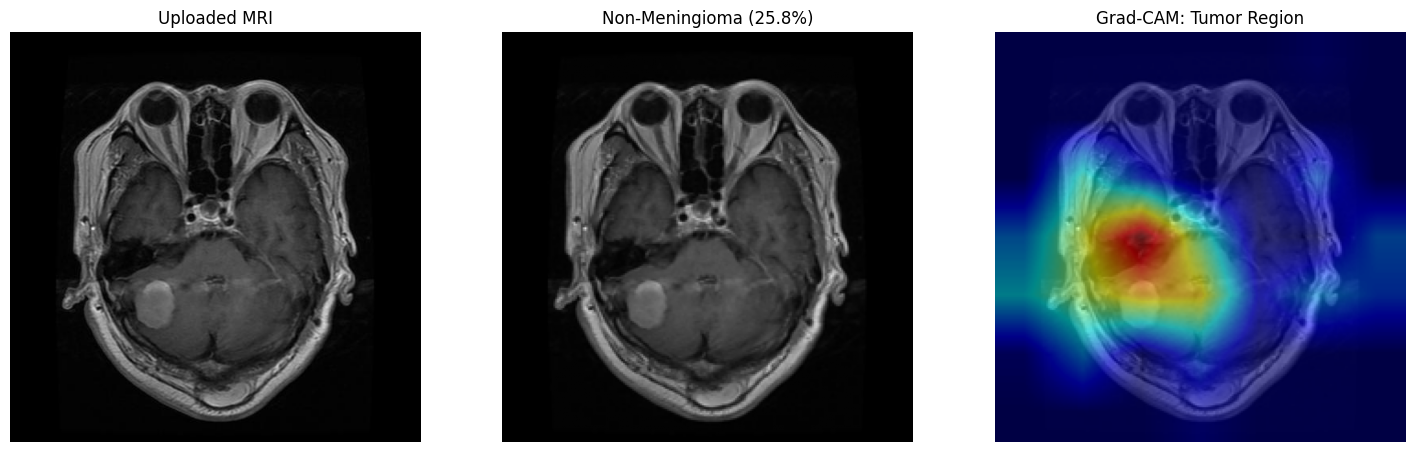

{'probability_meningioma': 0.2577776610851288, 'predicted_class': 'Non-Meningioma', 'heatmap': array([[[ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68],
        ...,
        [ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68]],

       [[ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68],
        ...,
        [ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68]],

       [[ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68],
        ...,
        [ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68]],

       ...,

       [[ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68],
        ...,
        [ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68]],

       [[ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68],
        ...,
        [ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68]],

       [[ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68],
        ...,
        [ 0,  0, 68],
        [ 0,  0, 68],
        [ 0,  0, 68]]], shape=(224

In [28]:
import os
import glob

meningioma_test_dir = '/kaggle/input/datasets/adrianvethanayagam/meningioma-datasetzip/Meningioma-Dataset/Testing/meningioma'
images = glob.glob(os.path.join(meningioma_test_dir, '*.jp*g'))  # catches .jpg and .jpeg

if images:
    test_image = images[0]  # first one
    print(f"Using image: {test_image}")
    result = infer_new_mri(test_image, show=True)
    print(result)
else:
    print("No images found in", meningioma_test_dir)


--- Test Image 1 ---


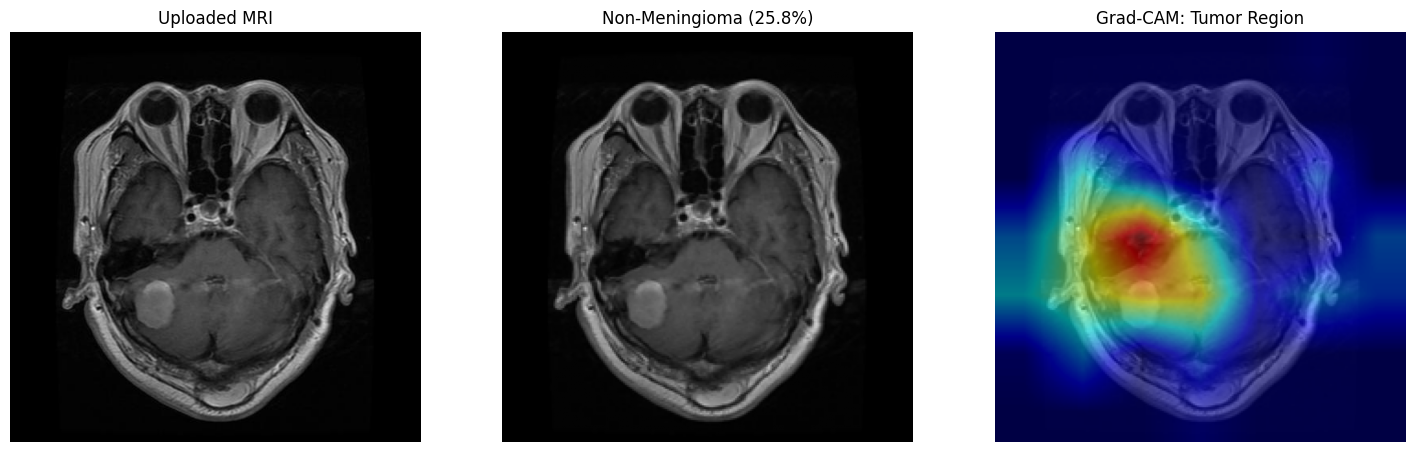


--- Test Image 2 ---


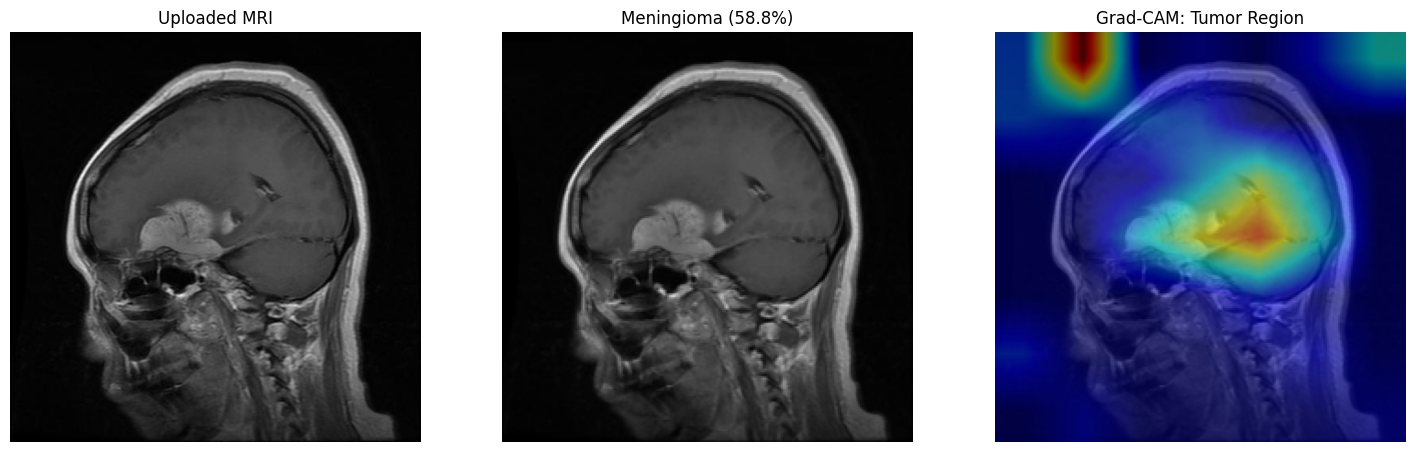


--- Test Image 3 ---


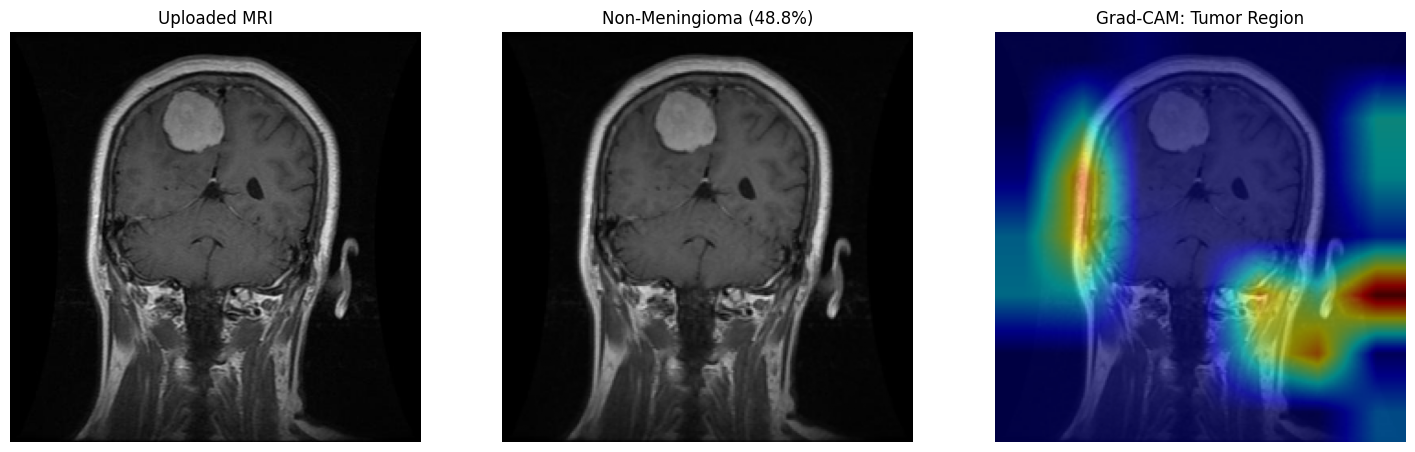

In [29]:
for i, img_path in enumerate(images[:3], 1):
    print(f"\n--- Test Image {i} ---")
    infer_new_mri(img_path, show=True)